In [1]:
import torch, time, pickle,os
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
import networkx as nx

In [2]:
def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

In [121]:


cols=np.array([0,2,4,5,6,7,8,10])
icols=np.array([1,3])

In [122]:
def create_graphs(tcols=[0,2,4,5,6,7,8,10,28], target=8, lim=10.5, case='test', transform='quantile', maxs=[1,1,1]):
    
    datm, dats, datb=[], [], []
    tcols=np.array(tcols)
    raw_path='../../../../tigress/mcranmer/merger_trees/isotrees/'
    target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
    transform_path=f'../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
    scaler=pickle.load(open(transform_path, 'rb'))
    not_include=np.array([0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]) 
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3])
    load_cols=np.sort(np.concatenate([tcols,icols]))
    not_include=not_include[load_cols]
    start=time.time()
    for i in range(0, maxs[0]):
        for j in range(0,maxs[1]):
            for k in range(0, maxs[2]):
                print(f'Loading isotree {i}_{j}_{k}')
                pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                print(f'isotree {i}_{j}_{k} loaded, restructuring')
                
                raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                del pd1
                
                trees=raw[raw.isna()['desc_id(3)']] 
                halos=raw[~raw.isna()['desc_id(3)']]
                del raw
                
                mask=halos.dtypes.values[1:]=='O'

                f,it="float64", "int64"
                map1=[]
                map2=[]
                q=0
                for l in load_cols:
                    q+=1
                    if l<25:
                        map1.append(l)
                        map2.append(q)
                map1=np.array(map1)
                map2=np.array(map2)

                castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                castto=castto[map1]
                dicts = {}
                keys = halos.columns[map2]
                for d, key in enumerate(keys):
                        dicts[key] = castto[d]

                halos=halos.astype(dicts)
                
                ## initial scaling
                hard=[0,2,15]
                def logit(x):
                    return np.log10((x+0.001)/(1.01-x))
                ##logit transform the hards
                for h in hard:
                    if h in tcols:
                        h1=np.where(load_cols==h)[0][0]+1
                        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

                log=[10,38, 39, 40, 41, 42]

                def logt(x):
                    return np.log10(x+1)
                for l in log:
                    if l in tcols:
                        l1=np.where(load_cols==l)[0][0]+1
                        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

                scale_cols=np.array(tcols[~is_cat[tcols]])

                print(f'Splitting to tree and scaling')
                spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
                splits=[]
                for s in spli:
                    if s[0,np.where(load_cols==10)[0][0]]>lim:
                        splits.append(s)
                splits=np.array(splits, dtype=object)
                split=[]
                for tree in splits:
                    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                    for n in scale_cols:
                        n1=np.where(load_cols==n)[0][0]
                        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
                    split.append(s)
                split=np.array(split, dtype=object)
                print('Split done')
                print('Loading targets')
                ex=f'{i}_{j}_{k}/galprop_0-99.dat'
                pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
                newcols=pdc.iloc[:,0]
                pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
                pds.columns=np.array(newcols)
                pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
                pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

                rhalid=np.array(pdcen[pds.columns[2]])
                del pd0
                del pds
                halwgal=[]
                ids=[]
                out=[]
                for idx, tree in enumerate(split): #split up into tree
                    if tree[0,1] in rhalid:
                        halwgal.append(tree)
                        ids.append(idx)
                        index=np.where(rhalid==tree[0,1])
                        out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
                del pdcen

                hraw=np.array(splits[ids], dtype=object)
                hals=[]
                pr,de=[],[]
                print('Making merger tree')
                for n in tqdm(range(len(halwgal))):
                    h=halwgal[n]
                    roots=h[h[:,4]==0]
                #     mergers=h[np.logical_and(h[:,4]>1,h[:,3]!=-1)] #remove self-loop, is broken since some roots go directly to final
                    mergers=h[h[:,4]>1]
                    final=h[h[:,3]==-1]
                    pro, des=[],[]
                    for r in roots:
                        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])]
                        while descid not in mergers[:,1]:
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])] #consider adding the number of steps it went through
                        pro.append(r[1])
                        des.append(descid[0])
                    m=mergers[mergers[:, 0].argsort()] #sort by redshift, starting at early times
                    mdes,mpro=list(m[:,1][1:]), list(m[:,1])
                    des+=mdes
                    pro+=mpro
                    des.append(final[:,1][0])
                    des,pro=convert(des[::-1],pro[::-1])
                    hal2=np.vstack([final,np.flip(m,axis=0).copy(),np.flip(roots,axis=0).copy()])
                    global fcols
                    if n==0:
                        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
                    hal2=hal2[:,fcols] ##take away id's
                    hals.append(hal2)
                    pr.append([int(p) for p in pro])
                    de.append([int(d) for d in des])
                hals=np.array(hals,dtype=object)
                out=np.log(out)/5 #homemade scaling
                for n in tqdm(range(len(out))):
                    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
                    x = torch.tensor(hals[n], dtype=torch.float)

                    y=torch.tensor(out[n], dtype=torch.float)
                    graph=Data(x=x, edge_index=edge_index, y=y)
                    dat.append(graph)
                stop=time.time()
                print(f'Done with tree. \n Time elapsed {stop-start} s')
    print("Saving dataset")
    if not osp.exists(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
        os.mkdir(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

    with open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
        pickle.dump(dat, handle)
    return dat

#     return split


In [127]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,25,35]+list(range(37,60)))

dat=create_graphs(tcols=all_cols, maxs=[1,1,1], lim=10, case='medium_all')

Loading isotree 0_0_0


/tmp/ipykernel_1384/1378001907.py:4: DtypeWarning: Columns (0,1,2,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[1,1,1], lim=10, case='medium_all')


isotree 0_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|███████████████████████████████████████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 16672.45it/s]


Done with tree. 
 Time elapsed 116.14485549926758 s
Saving dataset


In [128]:
xs=[]
ls=[]
for d in dat:
    xs.append(d.x.numpy())
    ls.append(len(d.x.numpy()))
xs=np.vstack(xs)

(array([118., 324., 163.,  90.,  39.,  15.,  11.,   4.,   4.,   1.]),
 array([1.14612804, 1.4554001 , 1.76467216, 2.07394423, 2.38321629,
        2.69248836, 3.00176042, 3.31103249, 3.62030455, 3.92957662,
        4.23884868]),
 <BarContainer object of 10 artists>)

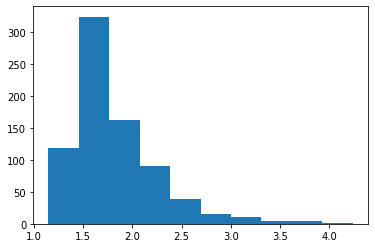

In [132]:
plt.hist(np.log10(ls))

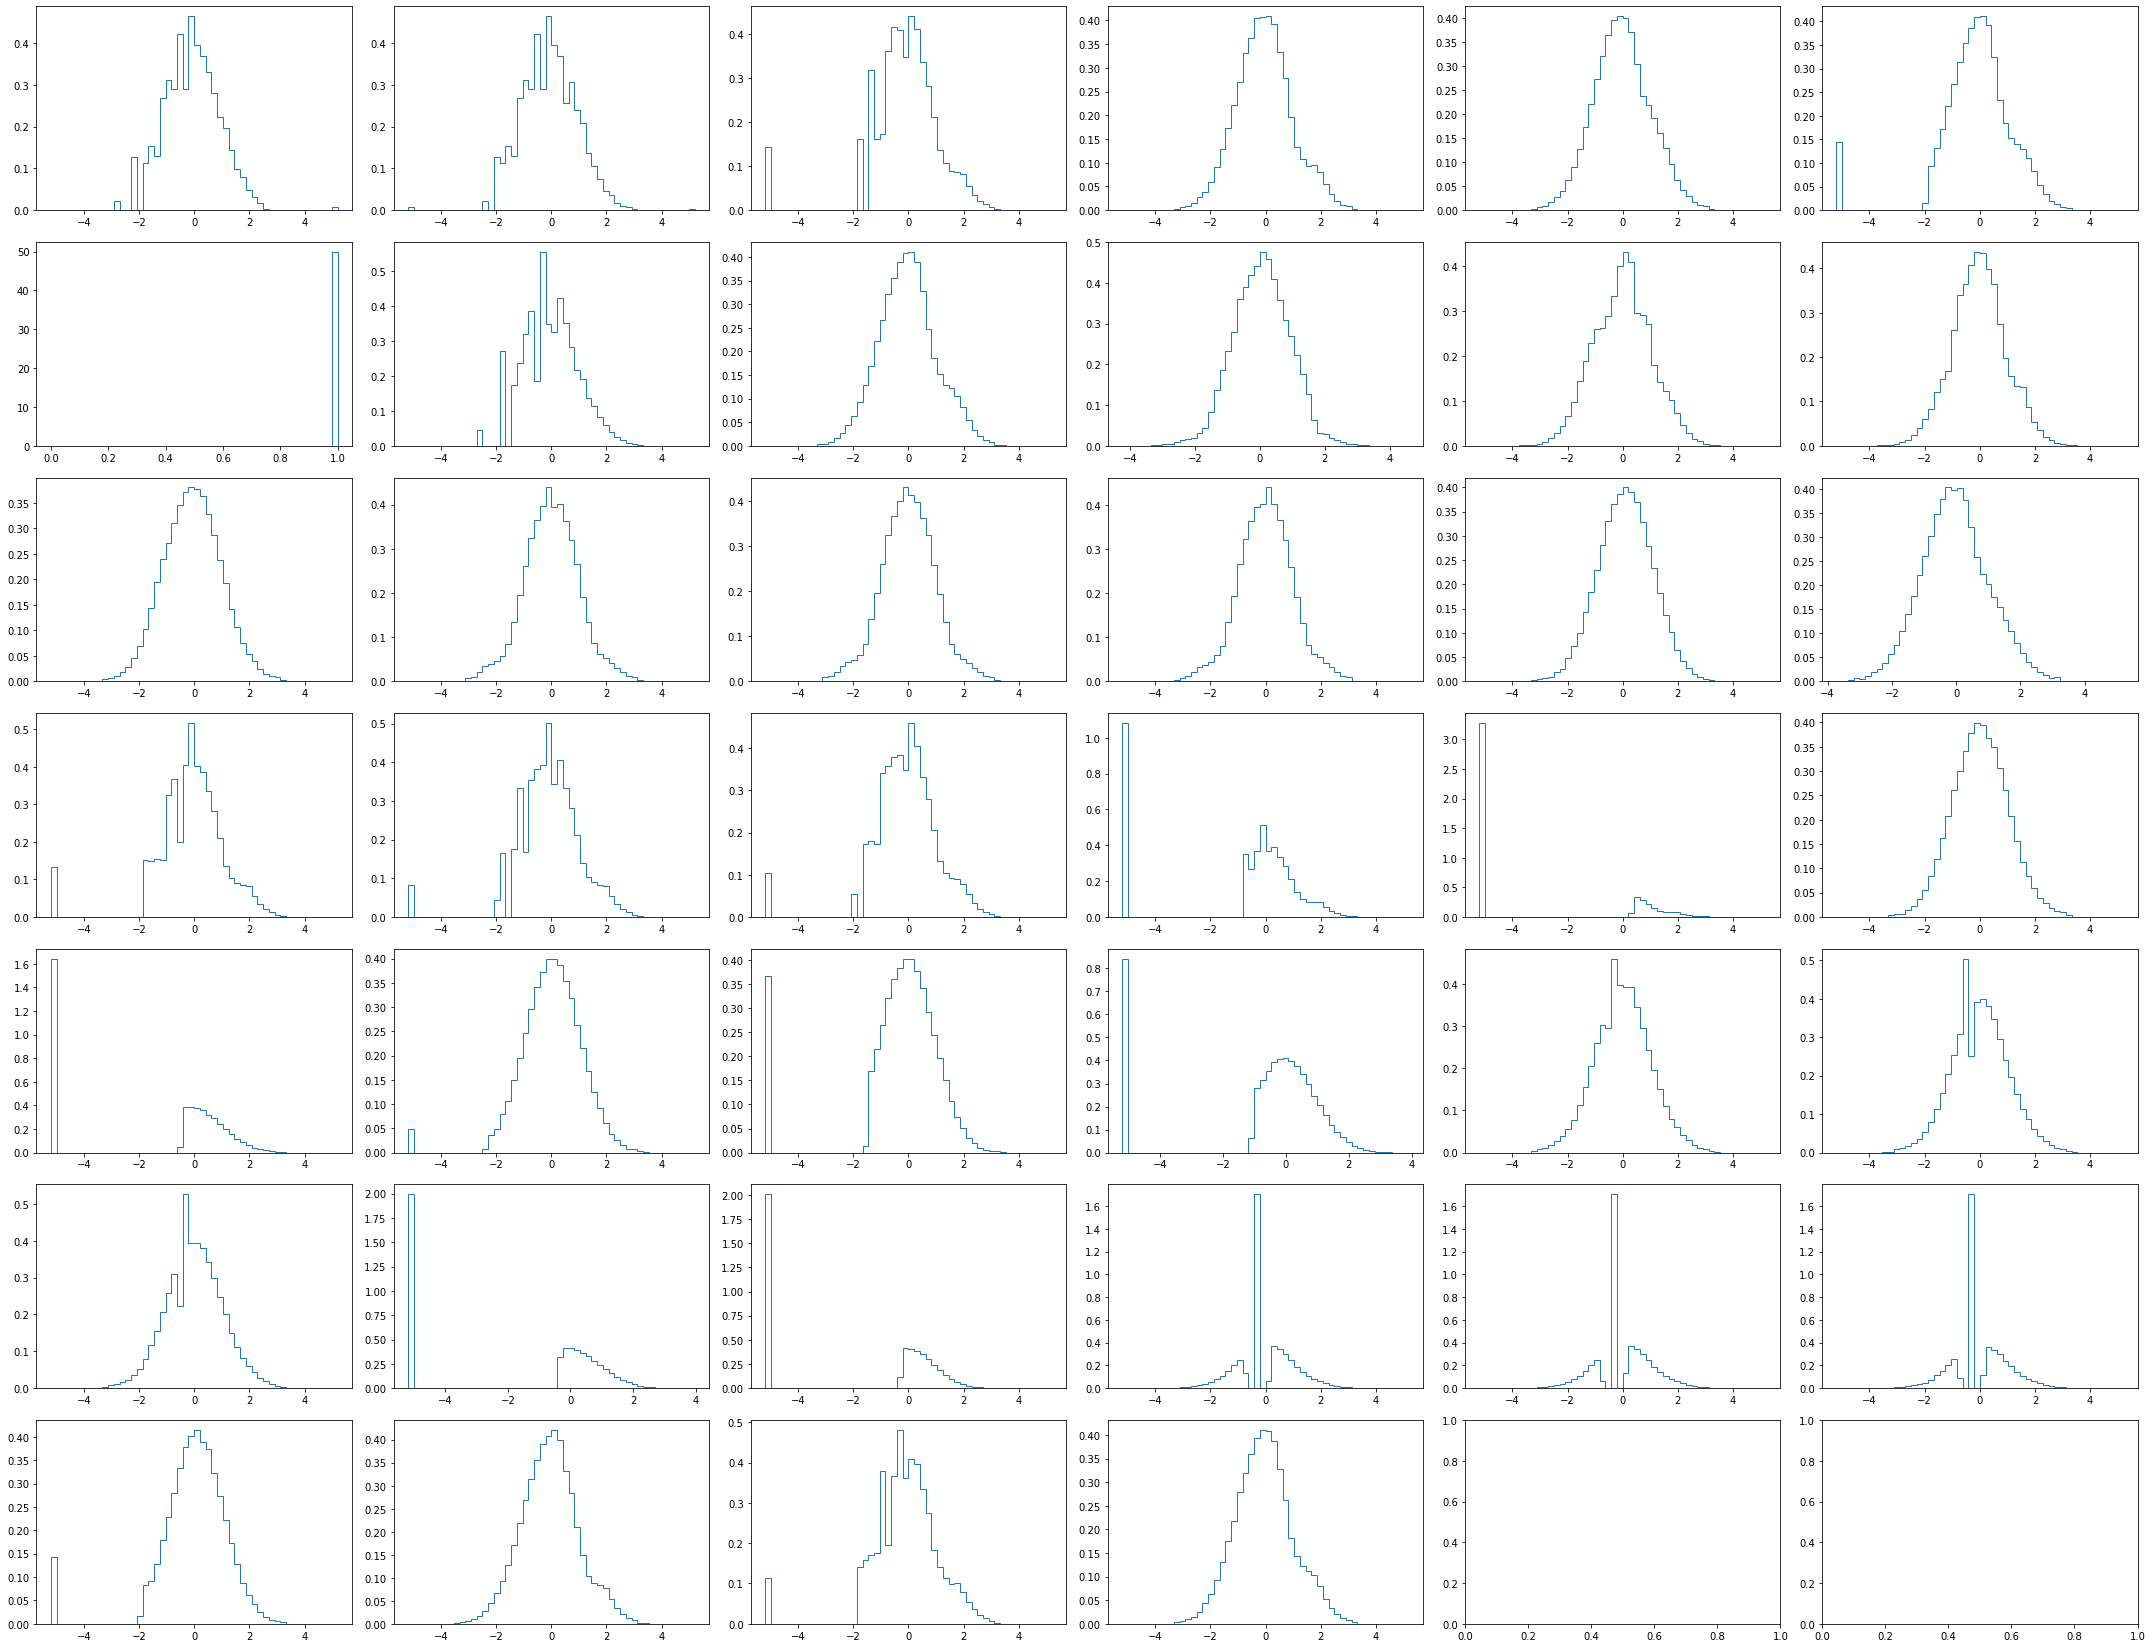

In [126]:
fig,ax=plt.subplots(nrows=7,ncols=6, figsize=(30,23))
ax=ax.flatten()
for i in range(len(xs[0])):
    ax[i].hist(xs[:,i], bins=50, density=1, histtype='step');
#     ax[i].set(title=halos.columns[np.array(fcols)+1][i])
# plt.hist(a[:,n], bins=100, density=1);
fig.tight_layout()

In [80]:
castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f,f])
castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])
len(castto)

25

In [50]:
load_cols=np.array([0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
f,it="float64", "int64"
maps=[]
for m in load_cols:
    if m<=26:
        maps.append(m)
maps=np.array(maps)
castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f,f])

In [24]:
load_cols

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 35, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [16]:
maps, len(castto), castto[maps], castto

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 26,
 array(['float64', 'int64', 'float64', 'int64', 'int64', 'int64', 'int64',
        'int64', 'int64', 'float64', 'float64', 'float64', 'float64',
        'int64', 'float64', 'float64', 'float64', 'float64', 'float64',
        'float64', 'float64', 'float64', 'float64', 'float64', 'float64'],
       dtype='<U7'),
 array(['float64', 'int64', 'float64', 'int64', 'int64', 'int64', 'int64',
        'int64', 'int64', 'float64', 'float64', 'float64', 'float64',
        'float64', 'int64', 'float64', 'float64', 'float64', 'float64',
        'float64', 'float64', 'float64', 'float64', 'float64', 'float64',
        'float64'], dtype='<U7'))

In [20]:
halos

,index,#scale(0),id(1),desc_scale(2),desc_id(3),num_prog(4),pid(5),upid(6),desc_pid(7),phantom(8),...,A[z],b_to_a(500c),c_to_a(500c),A[x](500c),A[y](500c),A[z](500c),T/|U|,M_pe_Behroozi,M_pe_Diemer,Halfmass_Radius
1,51,1.00000,1122969403,0.00000,-1,1,-1,-1,-1,0,...,-0.59764,0.73477,0.30184,1.11307,-1.04583,-0.49679,0.6532,187100000.0,42000000.0,2.103
2,52,0.99057,1113370505,1.00000,1122969403,1,-1,-1,-1,0,...,-0.80679,0.63215,0.15637,0.72804,-0.80641,-0.81522,0.8323,248100000.0,48000000.0,1.678
3,53,0.97659,1103578712,0.99057,1113370505,1,-1,-1,-1,0,...,0.82788,0.80679,0.18344,-0.68020,1.36609,1.06240,0.7812,166800000.0,30000000.0,2.681
4,54,0.96738,1093866277,0.97659,1103578712,1,-1,-1,-1,0,...,1.62453,0.19157,0.13979,-0.71347,0.31104,1.71859,0.9205,183100000.0,36000000.0,2.670
5,55,0.95372,1084166184,0.96738,1093866277,1,-1,-1,-1,0,...,1.72263,0.53219,0.33932,-0.44511,0.40864,1.70194,0.5444,186600000.0,30000000.0,2.603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884349,4884399,0.62557,754249688,0.63453,765435978.0,1.0,-1.0,-1.0,-1.0,0.0,...,2.13641,0.75990,0.45814,0.80072,0.69614,2.14372,0.5525,154000000.0,6000000.0,3.489
4884350,4884400,0.61674,742999164,0.62557,754249688.0,1.0,-1.0,-1.0,-1.0,0.0,...,1.74596,0.55970,0.36708,1.11629,0.99403,1.74596,0.6376,177200000.0,30000000.0,2.730
4884351,4884401,0.60804,731685427,0.61674,742999164.0,1.0,-1.0,-1.0,-1.0,0.0,...,1.19227,0.47104,0.30776,1.14373,0.99976,1.19227,0.8559,201800000.0,48000000.0,1.864
4884352,4884402,0.59662,720303756,0.60804,731685427.0,1.0,-1.0,-1.0,-1.0,0.0,...,0.48832,0.58741,0.35526,0.65286,1.69596,0.35190,0.7588,205000000.0,42000000.0,2.343


In [48]:
mask=halos.dtypes.values[1:]=='O'
top=max(np.array(load_cols)[mask])+1
print(top)
f,it="float64", "int64"
maps=[]
for l in load_cols:
    if l<=25:
        maps.append(l)
maps=np.array(maps)
castto1=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f,f])
castto=castto1[maps]
dicts = {}
keys = halos.columns[1:top]
for d, key in enumerate(keys):
            print(key, castto[d])
#         dicts[key] = castto[d]
# halos=halos.astype(dicts)

25
#scale(0) float64
id(1) int64
desc_scale(2) float64
desc_id(3) int64
num_prog(4) int64
pid(5) int64
upid(6) int64
desc_pid(7) int64
phantom(8) int64
Mvir(10) float64
Rvir(11) float64
rs(12) float64
vrms(13) float64
mmp?(14) int64
scale_of_last_MM(15) float64
vmax(16) float64
x(17) float64
y(18) float64
z(19) float64
vx(20) float64
vy(21) float64
vz(22) float64
Jx(23) float64
Jy(24) float64


In [99]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,24,25,35]+list(range(37,60)))

target=8
lim=11
case='test'
transform='quantile'
maxs=[1,1,1]
dat=[]
tcols=np.array(all_cols)
raw_path='../../../../tigress/mcranmer/merger_trees/isotrees/'
target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
transform_path=f'../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
scaler=pickle.load(open(transform_path, 'rb'))
not_include=np.array([0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]) 
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]
is_cat=np.array([bool(i) for i in is_cat])
icols=np.array([1,3])
load_cols=np.sort(np.concatenate([tcols,icols]))
not_include=not_include[load_cols]
start=time.time()
for i in range(0, maxs[0]):
    for j in range(0,maxs[1]):
        for k in range(0, maxs[2]):
            print(f'Loading isotree {i}_{j}_{k}')
            pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
            print(f'isotree {i}_{j}_{k} loaded, restructuring')

            raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
            del pd1

            trees=raw[raw.isna()['desc_id(3)']] 
            halos=raw[~raw.isna()['desc_id(3)']]
            del raw
 



Loading isotree 0_0_0
isotree 0_0_0 loaded, restructuring


In [104]:
mask=halos.dtypes.values[1:]=='O'

f,it="float64", "int64"
map1=[]
map2=[]
k=0
for l in load_cols:
    k+=1
    if l<25:
        map1.append(l)
        map2.append(k)
map1=np.array(map1)
map2=np.array(map2)

castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

castto=castto[map1]
dicts = {}
keys = halos.columns[map2]
for d, key in enumerate(keys):
        dicts[key] = castto[d]

halos=halos.astype(dicts)

25 [ 0  1  2  3  4  6  7  8 10 11 12 13 14 15 16 17 18 19 22 23 24] 21


{'#scale(0)': 'float64',
 'id(1)': 'int64',
 'desc_scale(2)': 'float64',
 'desc_id(3)': 'int64',
 'num_prog(4)': 'int64',
 'upid(6)': 'int64',
 'desc_pid(7)': 'int64',
 'phantom(8)': 'int64',
 'Mvir(10)': 'float64',
 'Rvir(11)': 'float64',
 'rs(12)': 'float64',
 'vrms(13)': 'float64',
 'mmp?(14)': 'int64',
 'scale_of_last_MM(15)': 'float64',
 'vmax(16)': 'float64',
 'x(17)': 'float64',
 'y(18)': 'float64',
 'z(19)': 'float64',
 'vz(22)': 'float64',
 'Jx(23)': 'float64',
 'Jy(24)': 'float64'}

In [105]:

halos=halos.astype(dicts)

In [106]:
for k, c in zip(keys, castto):
    print(k,c)

#scale(0) float64
id(1) int64
desc_scale(2) float64
desc_id(3) int64
num_prog(4) int64
upid(6) int64
desc_pid(7) int64
phantom(8) int64
Mvir(10) float64
Rvir(11) float64
rs(12) float64
vrms(13) float64
mmp?(14) int64
scale_of_last_MM(15) float64
vmax(16) float64
x(17) float64
y(18) float64
z(19) float64
vz(22) float64
Jx(23) float64
Jy(24) float64


In [ ]:
## initial scaling
hard=[0,2,15]
def logit(x):
    return np.log10((x+0.001)/(1.01-x))
##logit transform the hards
for h in hard:
    if h in tcols:
        h1=np.where(load_cols==h)[0][0]+1
        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

log=[10,38, 39, 40, 41, 42]

def logt(x):
    return np.log10(x+1)
for l in log:
    if l in tcols:
        l1=np.where(load_cols==l)[0][0]+1
        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

scale_cols=np.array(tcols[~is_cat[tcols]])

print(f'Splitting to tree and scaling')
spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
splits=[]
for s in spli:
    if s[0,np.where(load_cols==10)[0][0]]>lim:
        splits.append(s)
splits=np.array(splits, dtype=object)
split=[]
for tree in splits:
    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
    for n in scale_cols:
        n1=np.where(load_cols==n)[0][0]
        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
    split.append(s)
split=np.array(split, dtype=object)
print('Split done')
print('Loading targets')
ex=f'{i}_{j}_{k}/galprop_0-99.dat'
pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
newcols=pdc.iloc[:,0]
pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
pds.columns=np.array(newcols)
pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

rhalid=np.array(pdcen[pds.columns[2]])
del pd0
del pds
halwgal=[]
ids=[]
out=[]
for idx, tree in enumerate(split): #split up into tree
    if tree[0,1] in rhalid:
        halwgal.append(tree)
        ids.append(idx)
        index=np.where(rhalid==tree[0,1])
        out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
del pdcen

hraw=np.array(splits[ids], dtype=object)
hals=[]
pr,de=[],[]
print('Making merger tree')
for n in tqdm(range(len(halwgal))):
    h=halwgal[n]
    roots=h[h[:,4]==0]
#     mergers=h[np.logical_and(h[:,4]>1,h[:,3]!=-1)] #remove self-loop, is broken since some roots go directly to final
    mergers=h[h[:,4]>1]
    final=h[h[:,3]==-1]
    pro, des=[],[]
    for r in roots:
        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])]
        while descid not in mergers[:,1]:
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])] #consider adding the number of steps it went through
        pro.append(r[1])
        des.append(descid[0])
    m=mergers[mergers[:, 0].argsort()] #sort by redshift, starting at early times
    mdes,mpro=list(m[:,1][1:]), list(m[:,1])
    des+=mdes
    pro+=mpro
    des.append(final[:,1][0])
    des,pro=convert(des[::-1],pro[::-1])
    hal2=np.vstack([final,np.flip(m,axis=0).copy(),np.flip(roots,axis=0).copy()])
    global fcols
    if n==0:
        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
    hal2=hal2[:,fcols] ##take away id's
    hals.append(hal2)
    pr.append([int(p) for p in pro])
    de.append([int(d) for d in des])
hals=np.array(hals,dtype=object)
out=np.log(out)/5 #homemade scaling
for n in tqdm(range(len(out))):
    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
    x = torch.tensor(hals[n], dtype=torch.float)

    y=torch.tensor(out[n], dtype=torch.float)
    graph=Data(x=x, edge_index=edge_index, y=y)
    dat.append(graph)
stop=time.time()
print(f'Done with tree. \n Time elapsed {stop-start} s')
print("Saving dataset")
if not osp.exists(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
os.mkdir(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

with open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
pickle.dump(dat, handle)
